# Практика по базовой математической статистике для Data scientist

# Практика 4 - поиск аномалий в данных

На практическом занятии научимся находить аномалии в датасете при помощи python. 

- ищем и фильтруем аномалии в синтетических и реальных данных при помощи pandas и numpy
- делаем выводы по полученной статистике.

Для начала импортируем все полезные библитеки и настроим ноутбук

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.datasets import load_diabetes

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

Для работы подготовим синтетические данные - чтобы было интереснее, пусть это будет нормальное распределение N(1000, 5000) и смесь двух нормальных распределений https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.lognormal.html

Размер первой и второй выборки - 50000, третьей - 10000

In [2]:
ns = 50000
ns_sub = 1000
n_mean = 1000
n_sigma = 5000

n1_mean = 2000
n2_mean = 6000

n1_sigma = 500
n2_sigma = 1000

In [3]:
# Нормальное распределение.
dfn = np.random.normal(n_mean, n_sigma, ns)
dfn = pd.DataFrame(dfn,columns = ["volume"])
dfn.volume = round(dfn.volume,0)

In [4]:
# Смесь нормалаьных распределение.
l1 = np.random.normal(n1_mean, n1_sigma, ns)
l2 = np.random.normal(n2_mean, n2_sigma, ns)
dfl1 = pd.DataFrame(l1,columns = ["volume"])
dfl1.volume = round(dfl1.volume,0)

dfl2 = pd.DataFrame(l2,columns = ["volume"])
dfl2.volume = round(dfl2.volume,0)

dfl = dfl1.append(dfl2)

Посмотрим на гистограммы каждой выборки

Text(0.5, 1.0, 'Гистограмма первой выборки')

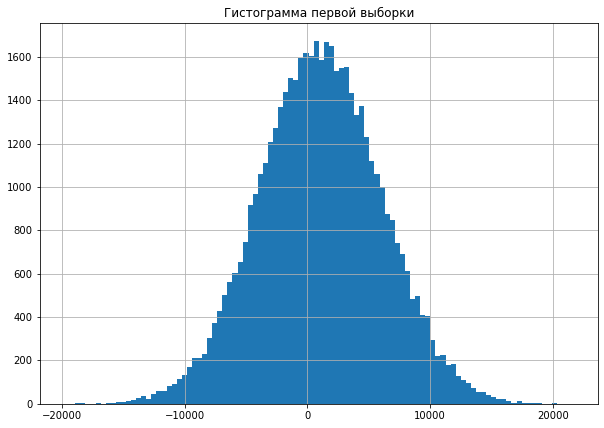

In [5]:
dfn.hist(bins = 100)
plt.title("Гистограмма первой выборки")

Text(0.5, 1.0, 'Гистограмма второй выборки')

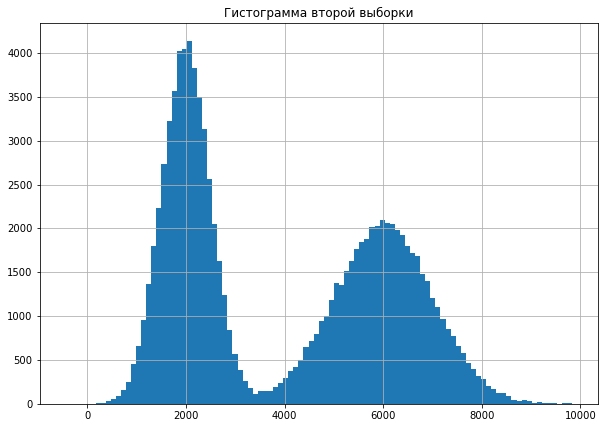

In [6]:
dfl.hist(bins = 100)
plt.title("Гистограмма второй выборки")

Посмотрим описательную статистику для каждой из выборок

In [7]:
dfn.describe()

,volume
count,50000.000000
mean,1050.072060
std,4984.432419
min,-19765.000000
25%,-2326.250000
50%,1026.000000
75%,4407.250000
max,21594.000000


In [8]:
dfl.describe()

,volume
count,100000.00000
mean,4001.14377
std,2155.28170
min,-455.00000
25%,1997.00000
50%,3335.00000
75%,6008.00000
max,9835.00000


В первом случае у нас классическое нормальное распределение, поэтому воспользуемся правилом трех сигм

In [9]:
upper_level = dfn.volume.mean() + 3*dfn.volume.std()
lower_level = dfn.volume.mean() - 3*dfn.volume.std()
print(lower_level,upper_level)

-13903.225196127272 16003.369316127273


Дополнительноо добавим 99 квантиль для отбора совсем крупных значений

In [10]:
level_99 = np.percentile(dfn.volume, 99)

Нарисуем полученный коридор на графике

Text(0.5, 1.0, '3 sigma и 99 квантиль для нормального распределения')

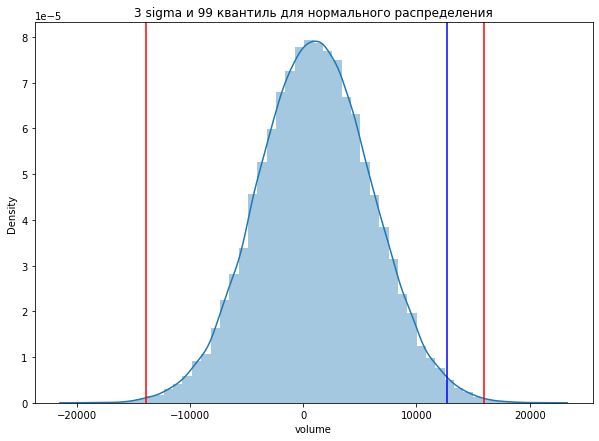

In [11]:
sns.distplot(dfn.volume)
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.axvline(x=level_99, color="b", linestyle="-")
plt.title("3 sigma и 99 квантиль для нормального распределения")

Можно заметить, что правило трех сигм дает далее более жесткий фильтр, чем 99 квантиль.

Отфильтруем данные свыше трех сигм:

In [12]:
dfn[dfn.volume >= upper_level].describe()

,volume
count,63.000000
mean,17317.523810
std,1264.031222
min,16022.000000
25%,16251.500000
50%,17080.000000
75%,17854.000000
max,21594.000000


А что со вторым датасетом? Это совершенноо точно бимодальное распределение. Убедимся, что в данном случае варианты выше не сработают.

-13903.225196127272 16003.369316127273
12681.030000000006


Text(0.5, 1.0, '3 sigma и 99 квантиль для бимодального распределения')

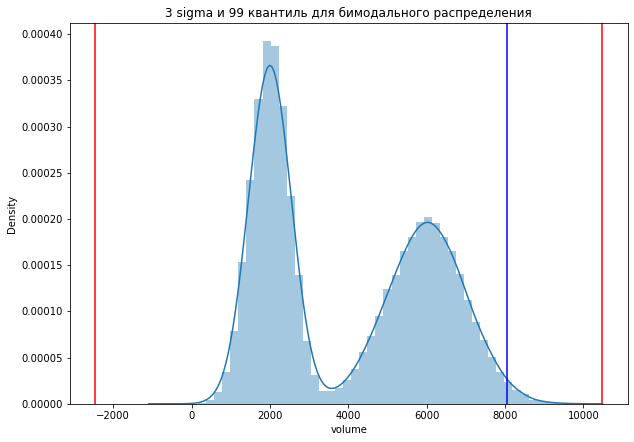

In [13]:
b_upper_level = dfl.volume.mean() + 3*dfl.volume.std()
b_lower_level = dfl.volume.mean() - 3*dfl.volume.std()
print(lower_level,upper_level)

b_level_99 = np.percentile(dfl.volume, 99)
print(level_99)

sns.distplot(dfl.volume)
plt.axvline(x=b_lower_level, color="r", linestyle="-")
plt.axvline(x=b_upper_level, color="r", linestyle="-")
plt.axvline(x=b_level_99, color="b", linestyle="-")
plt.title("3 sigma и 99 квантиль для бимодального распределения")

Да, получилось не очень. В таких случаях стоит разбить данные на кластеры - даже самым простым способом и исследовать их отдельно.
Весьма вероятно, что одна из групп и является аномальной)

Теперь оформим наши заготовки в функцию, оставив верхнюю границу от правил трех сигм и 99 квантиль, и проверим на реальных данных - медицинском датасете из набора sklearn https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes

In [14]:
def find_anomaly(df, column):
    upper_level = df[column].mean() + 3*df[column].std()
    level_99 = np.percentile(df[column], 99)
    anomaly = df[(df[column] >= upper_level)^(df[column] >= level_99)]
    return anomaly,upper_level,level_99

In [15]:
# Загрузим датасет
medical = load_diabetes()

In [16]:
# Посмотрим его описание
print(medical.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [17]:
# Загрузим фичи для анализа
df = pd.DataFrame(medical.data,columns = medical.feature_names)

# Добавим целевую переменную - цены на недвижимость
df["health_status"] = medical.target

# Переведем загловки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,health_status
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Найдем людей с аномальным показателем health_status

In [18]:
df.health_status.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: health_status, dtype: float64

In [19]:
anomaly = find_anomaly(df=df, column = "health_status")
len(anomaly[0])/len(df)

0.011312217194570135

Мы обнаружили 1 % необычных пациентов с самой высокой прогрессией болезни, и теперь можем выделить их в отдельную группу.

In [20]:
anomaly[0]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,health_status
32,0.034443,0.050680,0.125287,0.028758,-0.053855,-0.012900,-0.102307,0.108111,0.000271,0.027917,341.0
138,0.034443,0.050680,0.111276,0.076958,-0.031840,-0.033881,-0.021311,-0.002592,0.028017,0.073480,336.0
256,-0.049105,-0.044642,0.160855,-0.046985,-0.029088,-0.019790,-0.047082,0.034309,0.028017,0.011349,346.0
290,0.059871,0.050680,0.076786,0.025315,0.001183,0.016849,-0.054446,0.034309,0.029936,0.044485,332.0
362,0.019913,0.050680,0.104809,0.070073,-0.035968,-0.026679,-0.024993,-0.002592,0.003712,0.040343,321.0


Отметим найденные границы на распределении.

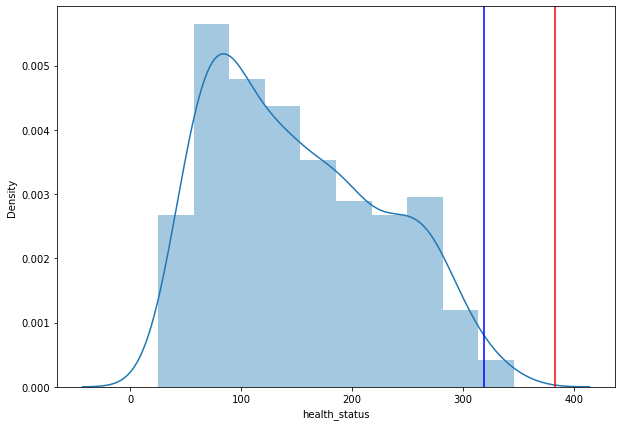

In [21]:
sns.distplot(df.health_status)
plt.axvline(x=anomaly[1], color="r", linestyle="-")
plt.axvline(x=anomaly[2], color="b", linestyle="-")

# Мини домашка

Добавьте в функцию find_anomaly обнаружение выбросов по 90 квантилю. Сколько пациентов попали в выборку?

In [26]:
def find_anomaly(df, column):
    upper_level = df[column].mean() + 3*df[column].std()
    level_99 = np.percentile(df[column], 99)
    level_90 = np.percentile(df[column], 90)
    anomaly = df[(df[column] >= upper_level)^(df[column] >= level_99)^(df[column] >= level_90)]
    return anomaly,upper_level,level_99,level_90

In [27]:
anomaly = find_anomaly(df=df, column = "health_status")
len(anomaly[0])/len(df)

0.09502262443438914